# HSE 2021: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net). 

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$.

The optimization problem with respect to the $w_0, w$ is the following (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format) 

##### Put your markdown formulas here

##### $$\nabla_w L(w,w_0)= -\frac{1}{N} \sum_i^N \frac{exp(-y_i (w^Tx_i+w_0))}{1+exp(-y_i (w^Tx_i+w_0))} y_i x_i + \gamma sign(w)+ 2 \beta w $$

##### $$\nabla_{w_0} L(w,w_0)= -\frac{1}{N} \sum_i^N \frac{exp(-y_i (w^Tx_i+w_0))}{1+exp(-y_i (w^Tx_i+w_0))}y_i $$

#### 2. [0.5 points] Implement the Elastic Net loss (as a function)

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    return 1/len(X) * np.sum(1 + np.exp(-y*(np.dot(X,np.transpose(w))+w0))) + gamma*np.sum(np.abs(w)) + beta * np.linalg.norm(w)

#### 3. [0.5 points] Implement the gradient (as a function)

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    tmp = np.exp(-y*(np.dot(X,np.transpose(w))+w0))
    grad_w0 = -1/len(X) * np.sum( tmp / (1+tmp) *y)
    grad_w = -1/len(X) * np.dot(tmp / (1+tmp)*y,X) +gamma*np.sign(w)+2*beta*w
    return grad_w, grad_w0

#### Check yourself

In [4]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844, 
                   rtol=1e-2)
)

####  4. [1 point]  Implement gradient descent and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [24]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):  
        self.beta = beta        
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.learning_rate = lr
        self.random_state = random_state
        self.threshold=0
        self.lossfunc = []
        # you may additional properties if you wish
        
    def fit(self, X, y):
        # add weights and bias and optimize Elastic Net loss over (X,y) dataset
        # save history of optimization steps
        
        np.random.seed(self.random_state)
        self.w = np.ones(np.array(X)[0].size)
        self.w0 = 1
        for i in range(self.max_iter):

            gw, gw0 = get_grad(X, y, self.w, self.w0, gamma = self.gamma, beta = self.beta)
            nw, nw0 = self.w - self.learning_rate * gw, self.w0 - self.learning_rate * gw0

            self.lossfunc.append(loss(X, y, self.w, self.w0, gamma = self.gamma, beta = self.beta))
            if(np.linalg.norm(nw - self.w) <= self.tolerance):
                self.w = nw
                self.w0 = nw0
                break
            self.w = nw
            self.w0 = nw0
                      
        fpr, tpr, thresholds = roc_curve(y,  self.predict_proba(X)[1,:])
        gmeans = np.sqrt(tpr * (1-fpr))
        x = np.argmax(gmeans)
        self.threshold= thresholds[x]
        return self

    
    def predict(self, X):
        prob=self.predict_proba(X)[1,:]  
        predict=np.where(prob<self.threshold,-1,1)
        return predict

        
    def predict_proba(self, X):
        return np.array([1 / (1 + np.exp(np.dot(X, self.w) + self.w0)),\
                         1 / (1 + np.exp(-np.dot(X, self.w) - self.w0))])

In [7]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [8]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    
    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

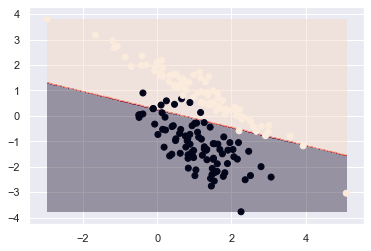

In [25]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

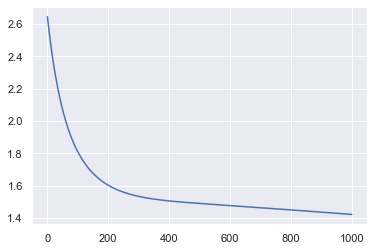

In [26]:
plt.plot(model.lossfunc)

## PART 2: Support Vector Machines

#### 6. [1 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient 

Show how these parameters affect accuracy, roc_auc and f1 score. 
Make plots for the dependencies between metrics and parameters. 
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

In [27]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
kernels = ['linear', 'poly', 'rbf']


accurancy = [[], [],[]]
rocauc = [[], [],[]]
f1 = [[], [],[]]


C=np.linspace(0.001, 3, 200)


X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=0)

for i in range(3):
    for c in C:
        clf =  SVC(kernel=kernels[i],C=c)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accurancy[i].append(accuracy_score(y_test,y_pred))
        rocauc[i].append(roc_auc_score(y_test,y_pred))
        f1[i].append(f1_score(y_test,y_pred))

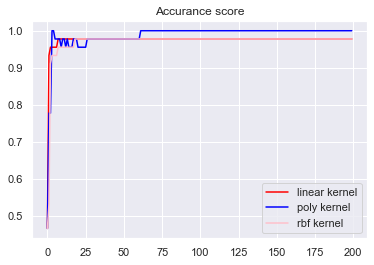

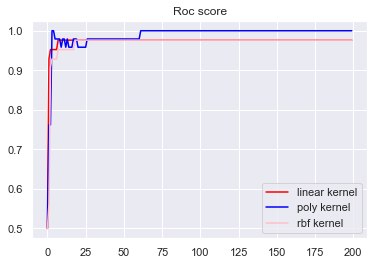

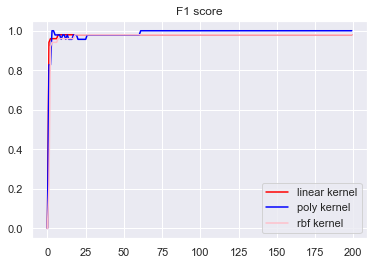

In [28]:

plt.plot(accurancy[0],label='linear kernel', color = 'red')
plt.plot(accurancy[1],label='poly kernel', color = 'blue')
plt.plot(accurancy[2],label='rbf kernel', color = 'pink')
plt.title("Accurance score")
plt.legend()
plt.show()
plt.plot(rocauc[0],label='linear kernel', color = 'red')
plt.plot(rocauc[1],label='poly kernel',color = 'blue')
plt.plot(rocauc[2],label='rbf kernel',color = 'pink')
plt.title("Roc score")
plt.legend()
plt.show()

plt.plot(f1[0],label='linear kernel', color = 'red')
plt.plot(f1[1],label='poly kernel',color = 'blue')
plt.plot(f1[2],label='rbf kernel',color = 'pink')
plt.title("F1 score")
plt.legend()
plt.show()

Вывод

## PART 3: Natural Language Processing

#### 7. [2 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors: 
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 100
    * fix random state and randomly choose sentences in the folowing proportion "30k : 15k : 7k : 20k: 40k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center> 
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr> 
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td> 
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td> 
        <tr><td> ... </td><td> ... </td><td> 
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset 
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and lemmatize the words
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

In [13]:
# your code here

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn) 

##### 1. 
* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 3/4 split rate (don't forget to fix the random state)
* train the models using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn) 
* make conclusions about the performance of your models

##### 2. 
* using GridSearchCV - find the best parameters for the models (by ROC_AUC score)
* make several plots to address the dependence between ROC_AUC score and parameters
* make conclusions about the models

In [14]:
# your code here

#### 9. [1 point] Analysing ROC_AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate 

In [15]:
# your code here

### Multiclass logit

#### 10. [1 point] Take the One-VS-Rest classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html">OneVsRestClassifier</a>

* use the whole dataset with 6 authors
* divide the data into train and test samples with 3/4 split rate
* train the model using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)
* using GridSearchCV - find the best parameters for the models (by averaged ROC_AUC score)
* make conclusions about the model

In [16]:
# your code here